In [2]:
import numpy as np
def getkurucz(teff, logg, metallicity=0.0):
    '''
    For a given Teff, log(g), and metallicity, retrieves the
    Kurucz & Castelli ATLAST9 stellar atmosphere models.
    Ideally it would interpolate these, but right now it just
    picks the closest match.
    As recommended by the STScI web site discussing synphot,
    we use the models with vturb=2 km/s and Delta(log(tau_ross))=0.125
    Currently we only read in the zero metallicity file, though more files
    could be added to select from in the future...
    
    INPUTS
    Teff: stellar effective temp (K)
    logg: log of surface gravity
    metallicity: currently only zero is allowed
    
    OUTPUTS
    lambda: wavelength vector (nm)
    Bnu: surface brightness (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    
    OPTIONAL OUTPUTS
    Bnucont: continuum surface brightness w/out line abosrptions (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    logg_model: best matching value of logg in the grid
    teff_model: best matching value of teff in the grid
    
    Vectors of logg and teff in the Kurucz model grid...
    '''
    
    gvec = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
    tvec = np.array([3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000,7250,7500,7750,8000,8250,8500,8750,9000,9250,9500,9750,10000,10250,10500,10750,11000,11250,11500,11750,12000,12250,12500,12750,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,44000,45000,46000,47000,48000,49000,50000])
    
    # First, some error handling...
    if teff > np.max(tvec): print('Teff too large.')
    if teff < np.min(tvec): print('Teff too small.')
    if logg > np.max(gvec): print('logg too large.')
    if logg < np.min(gvec): print('logg too small.')
    if metallicity != 0:
        print('Only [+0.0] metallicity currently allowed.')
        return
    
    # Open model grid file
    fin = open('fp00k2odfnew.pck','r')
    for i in range(0,22): fin.readline()

    # Read the wavelengths (in nm)
    lam = []
    line = fin.readline()
    while line.split()[0] != 'TEFF':
        entries = line.split()
        for l in entries: lam.append(float(l))
        line = fin.readline()
    lam = np.array(lam)
    nl = len(lam)
    
    # Must keep logg_model from going out of bounds
    teff_model = teff
    logg_model = logg
    if teff_model >= 6250: logg_model = max(logg_model, 0.5)
    if teff_model >= 7750: logg_model = max(logg_model, 1.0)
    if teff_model >= 8500: logg_model = max(logg_model, 1.5)
    if teff_model >= 9250: logg_model = max(logg_model, 2.0)
    if teff_model >= 12000: logg_model = max(logg_model, 2.5)
    if teff_model >= 20000: logg_model = max(logg_model, 3.0)
    if teff_model >= 27000: logg_model = max(logg_model, 3.5)
    if teff_model >= 32000: logg_model = max(logg_model, 4.0)
    if teff_model >= 40000: logg_model = max(logg_model, 4.5)
    if teff_model >= 50000: logg_model = max(logg_model, 5.0)
  
    # Get the fractional indices of the desired logg and teff
    if logg_model >= gvec[-1]: gindex = len(gvec)-2
    else: gindex = np.where(gvec >= logg_model)[0][0]-1
    if gindex<0: gindex = 0
    if gindex>=len(gvec)-1: gindex = len(gvec)-2
    fg = (logg_model - gvec[gindex]) / (gvec[gindex+1] - gvec[gindex])

    if teff_model >= tvec[-1]: tindex = len(tvec)-2
    else: tindex = np.where(tvec >= teff_model)[0][0]-1
    if tindex<0: tindex = 0
    if tindex>=len(tvec)-1: tindex = len(tvec)-2
    ft = (teff_model - tvec[tindex]) / (tvec[tindex+1] - tvec[tindex])
    
    Bnu00 = np.zeros(len(lam))
    Bnu01 = np.zeros(len(lam))
    Bnu10 = np.zeros(len(lam))
    Bnu11 = np.zeros(len(lam))
    
    while len(line)>0:
        if line.split()[0] == 'TEFF':
            tempt = float(line.split()[1])
            tempg = float(line.split()[3])

            if tempt==tvec[tindex] and tempg==gvec[gindex]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu00[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex] and tempg==gvec[gindex+1]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu01[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex+1] and tempg==gvec[gindex]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu10[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex+1] and tempg==gvec[gindex+1]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu11[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            else:
                try: line = fin.readline()
                except: break
        else:
            try: line = fin.readline()
            except: break
            
    Bnu0 = Bnu00 * (1.-fg) + Bnu01 * fg
    Bnu1 = Bnu10 * (1.-fg) + Bnu11 * fg
    Bnu = Bnu0 * (1.-ft) + Bnu1 * ft
    Bnu = Bnu * 4.
    
    '''
    IMPORTANT NOTE: The Kurucz flux data is in units of erg s^-1 cm^-2 Hz^-1 sr^-1.  This
    is the same units as surface brightness, so we might think that Kurucz is providing Bnu, where
    Fnu = pi * Bnu * (Rstar / d)^2 is the flux Fnu for a star of radius Rstar at distance d.  But in
    fact, for whatever reason, Kurucz is providing the quantity (pi * Bnu) / (4 * pi).  This is the
    surface flux per unit solid angle--this must be important in stellar atmospheres or something.
    Anyway, to calculate Bnu, which is what this routine returns, we multiply Kurucz's numbers by 4.
    If this sounds crazy to you, I note that this agrees with the SYNPHOT Data User's Guide, which
    can be found at http://www.stsci.edu/hst/HST_overview/documents/synphot/AppA_Catalogs9.html
    '''

    return lam,Bnu

In [3]:
lams, bnus = getkurucz(teff=5778.,logg=4.4)

def steflux(lam, lams, bnus, Rstar=1, sysdist=10):
    '''
    Inputs:
    lam: wavelength vector (nm)
    lams: wavelength vector of the stellar model (nm)
    bnus: surface brightness (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    Rstar: radius of star in solar radii
    sysdist: distance to star in parsecs
    
    Outputs:
    steflux: the "stellar flux" in Jy
    '''
    #return the "stellar flux" in Jy
    RstarAU = Rstar * 0.00465047  # radius of star in AU from Rstar in solar radii
    dstarAU = sysdist * 206265.    # distance to star in AU from sysdist in parsecs
    steflux = np.interp(lam,lams,bnus)* np.pi* (RstarAU / dstarAU)**2 * 1e23
    return steflux

if __name__ == '__main__':
    print(steflux(575,lams,bnus)) #Jy

48.1279944339343


In [5]:
def downsample_image(image, n, final_size):
    """Downsamples a 1D or 2D NumPy array by combining n^2 pixels into 1 pixel

    Args:
        image: A 1D or 2D NumPy array representing the image.

    Returns:
        A 2D NumPy array representing the downsampled image.
    """
    # Reshape the image into a 3D array
    image = image.reshape(final_size, n, final_size, n)

    # Average the pixels in each block
    return image.sum(axis=(1, 3))

In [ ]:
%%time
import itertools
import numpy as np
from astropy.io import fits
import tables
import os

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

wavelengths_nm = [575,660,730,825] # meter
Ds = {"3m":3,"6m":6,"LUVOIRB":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)

for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    desired_wavelength = wavelength_nm/1000
    fits_file = f'output/{i+100}-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits'
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break
        
        # Get the disk contrast cube
        disk_cube = hdul[2].data
        '''
        # Get header information from Extension 2
        diskheader = hdul[2].header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        print(pxsclmas == psf_scale*1000/2)
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        print(nypix == 2*target_pixel)
        # Get header information from Extension 4
        starheader = hdul[4].header
        system_inc = int(starheader['I'])
        print(system_inc == incs[i%8])
        '''
        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]

        super_disk = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e6/psf_scale**2
        # Plot the disk from contrast map and the star flux
        pre_imgs[i] =  downsample_image(super_disk, 2, target_pixel)

# Save the pre-processed images
if not os.path.exists('455_exovista.h5'):
    h5mode = 'w'
else:
    h5mode = 'a'
with tables.open_file('455_exovista.h5', h5mode) as fitsh5:
    fitsh5.create_array('/', 'vortex', pre_imgs)    

In [ ]:
%%time
import itertools
import numpy as np
from astropy.io import fits
import tables
import os

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

wavelengths_nm = [575,660,730,825] # meter
Ds = {"3m":3,"6m":6,"LUVOIRB":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)

for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    desired_wavelength = wavelength_nm/1000
    fits_file = f'output/{i+100}-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits'
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break
        
        # Get the disk contrast cube
        disk_cube = hdul[2].data
        '''
        # Get header information from Extension 2
        diskheader = hdul[2].header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        print(pxsclmas == psf_scale*1000/2)
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        print(nypix == 2*target_pixel)
        # Get header information from Extension 4
        starheader = hdul[4].header
        system_inc = int(starheader['I'])
        print(system_inc == incs[i%8])
        '''
        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]

        super_disk = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e6/psf_scale**2
        # Plot the disk from contrast map and the star flux
        pre_imgs[i] =  downsample_image(super_disk, 2, target_pixel)

# Save the pre-processed images
if not os.path.exists('455_exovista.h5'):
    h5mode = 'w'
else:
    h5mode = 'a'
with tables.open_file('455_exovista.h5', h5mode) as fitsh5:
    fitsh5.create_array('/', 'vortex', pre_imgs)    

0.9265801843126953


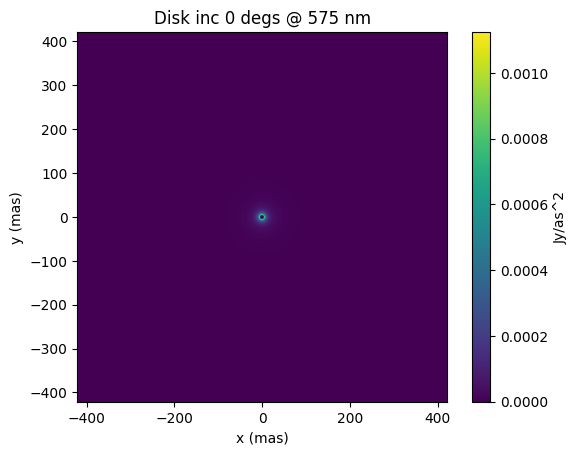

1.2354402457502605


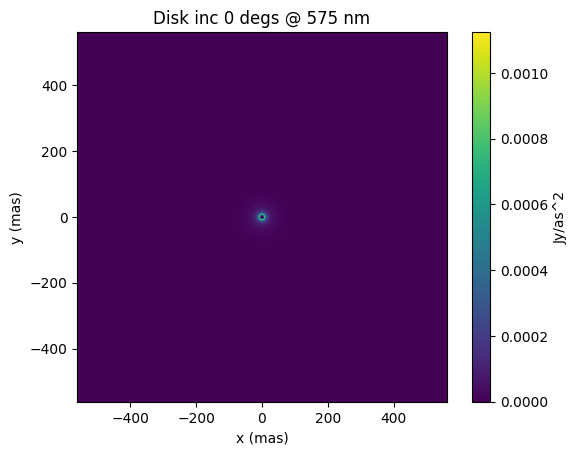

2.470880491500521


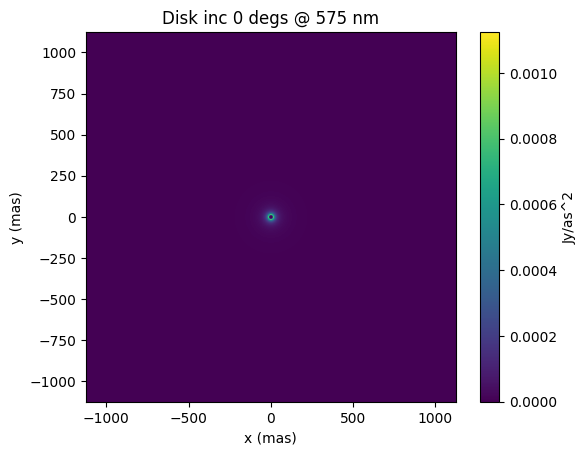

In [ ]:
import astropy.io.fits as fits
import os
import glob
from libmambapy import sign
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the output folder containing the FITS files
output_folder = 'output'

# Get a list of all FITS files in the output folder
fits_files = glob.glob(os.path.join(output_folder, '*.fits'))
# sort the files by the number in the filename
fits_files.sort(key=lambda x: int(x.split('/')[-1].split('-')[0]))

# Choose the desired wavelength (in microns)
desired_wavelength = 0.575  # Example: 1 micron

# Loop through each FITS file
for fits_file_number in [-1,-2,-3]:
    # Open the FITS file
    with fits.open(fits_files[fits_file_number]) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        '''
        NAXIS1: length of wavelength vector (# of wavelengths)
        SPECRES: spectral resolution of wavelength vector
        LAMMIN: minimum wavelength
        LAMMAX: maximum wavelength
        '''
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break

        # Get the disk contrast cube
        disk_cube = hdul[2].data

        # Get header information from Extension 2
        diskheader = hdul[2].header
        '''
        NAXIS1: # of pixels in x dimension
        NAXIS2: # of pixels in y dimension
        NAXIS3: # of wavelengths+1
        SPECRES: spectral resolution of wavelength vector
        PXSCLMAS: pixel scale in milli-arcseconds
        IWA: inner working angle of the coronagraph in arcseconds
        DUSTBLOW: the dust blowout particle size in microns
        TSUB: the dust sublimation temperature in kelvins
        LNGND-N: longitude of the ascending node of the Nth disk component (degrees)
        I-N: inclination of the Nth disk component relative to system midplane (degrees)
        NZODIS-N: density in zodis of the Nth disk component
        R-N: circumstellar distance of the peak density of the Nth disk component (AU)
        DROR-N: value of the normalized Gaussian peak width of the Nth disk component
        RINNER-N: value of the inner truncation radius of the Nth disk component (AU)
        ETA-N: ratio of PR drag time to collision time for the blowout size for the Nth disk component
        HOR-N: normalized scale height for the Nth disk component
        G0-N – G2-N: 3 values of scattering asymmetry parameters for the Nth disk component
        W0-N – W2-N: 3 weights for each HG scattering phase function for the Nth disk component
        MINSIZE: minimum grain size considered
        MAXSIZE: maximum grain size considered
        '''

        # Extract relevant parameters from the header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        iwa = diskheader['IWA']           # Inner working angle in arcseconds
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        #print(f'Pixel scale: {pxsclmas} mas/pixel')
        #print(f'Inner working angle: {iwa*1000} mas')
        #print(f'Number of pixels in x dimension: {nxpix}')
        #print(f'Number of pixels in y dimension: {nypix}')

        # Get header information from Extension 4
        starheader = hdul[4].header
        '''
        Key header parameters:
        NAXIS1: # of time values
        NAXIS2: # of data values (wavelengths+15) for each time value
        PA: position angle of system midplane (degrees)
        I: inclination of system midplane (degrees)
        STARID: an internal catalog ID # for the star
        RA: right ascension of star (decimal degrees)
        DEC: declination of star (decimal degrees)
        *MAG: stellar empirical magnitude in the * filter band
        M_V: absolute V-band magnitude of star
        DIST: distance to star (pc)
        TYPE: spectral type of star
        LSTAR: bolometric stellar luminosity (solar luminosities)
        TEFF: stellar effective temperature (K)
        ANGDIAM: angular diameter of star (mas)
        MASS: stellar mass (solar masses)
        LOGG: log(stellar gravity) (cm/s2)
        RSTAR: stellar radius (solar radii)
        WDS_SEP: most recent separation of companion in WDS catalog, if it exists (arcsec)
        WDS_DMAG: delta mag of companion in WDS catalog, if it exists
        PMRA: proper motion in RA (mas/yr)
        PMDEC: proper motion in DEC (mas/yr)
        PXSCLMAS: pixel scale (mas)
        '''
        system_inc = int(starheader['I'])   

        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]
        # Calculate the extent for plotting based on pixel scale and IWA
        extent = pxsclmas*np.array([-nxpix/2+0.5, nxpix/2-0.5, -nypix/2+0.5, nypix/2-0.5]) # in milliarcseconds

        # Plot the disk from contrast map and the star flux
        disk_img = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e6/pixel_scale**2
        
        plt.imshow(disk_img, extent=extent, cmap='viridis', origin='lower')
        plt.colorbar(label='Jy/as^2')
        plt.ylabel('y (mas)')
        
        print(pxsclmas)
        #np.save('../Toy_Coronagraph/tests/exovista'+str(system_inc)+'.npy', np.array([np.arange(extent[0], extent[1], pxsclmas), disk_img[nypix//2]]))
        #plt.plot(np.linspace(extent[0],extent[1],nxpix), disk_img[nxpix//2])
        #plt.ylabel('Jy/as^2')
        plt.title(f'Disk inc {system_inc} degs @ {int(desired_wavelength*1000)} nm')
        plt.xlabel('x (mas)')
        plt.show()
        plt.close()

0.000623549061068492 3.1279717870424175 1.2354402457502605 910
output/0-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits
0.0032894899920097756 3.1279717870424175 1.2354402457502605 910
output/4-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits


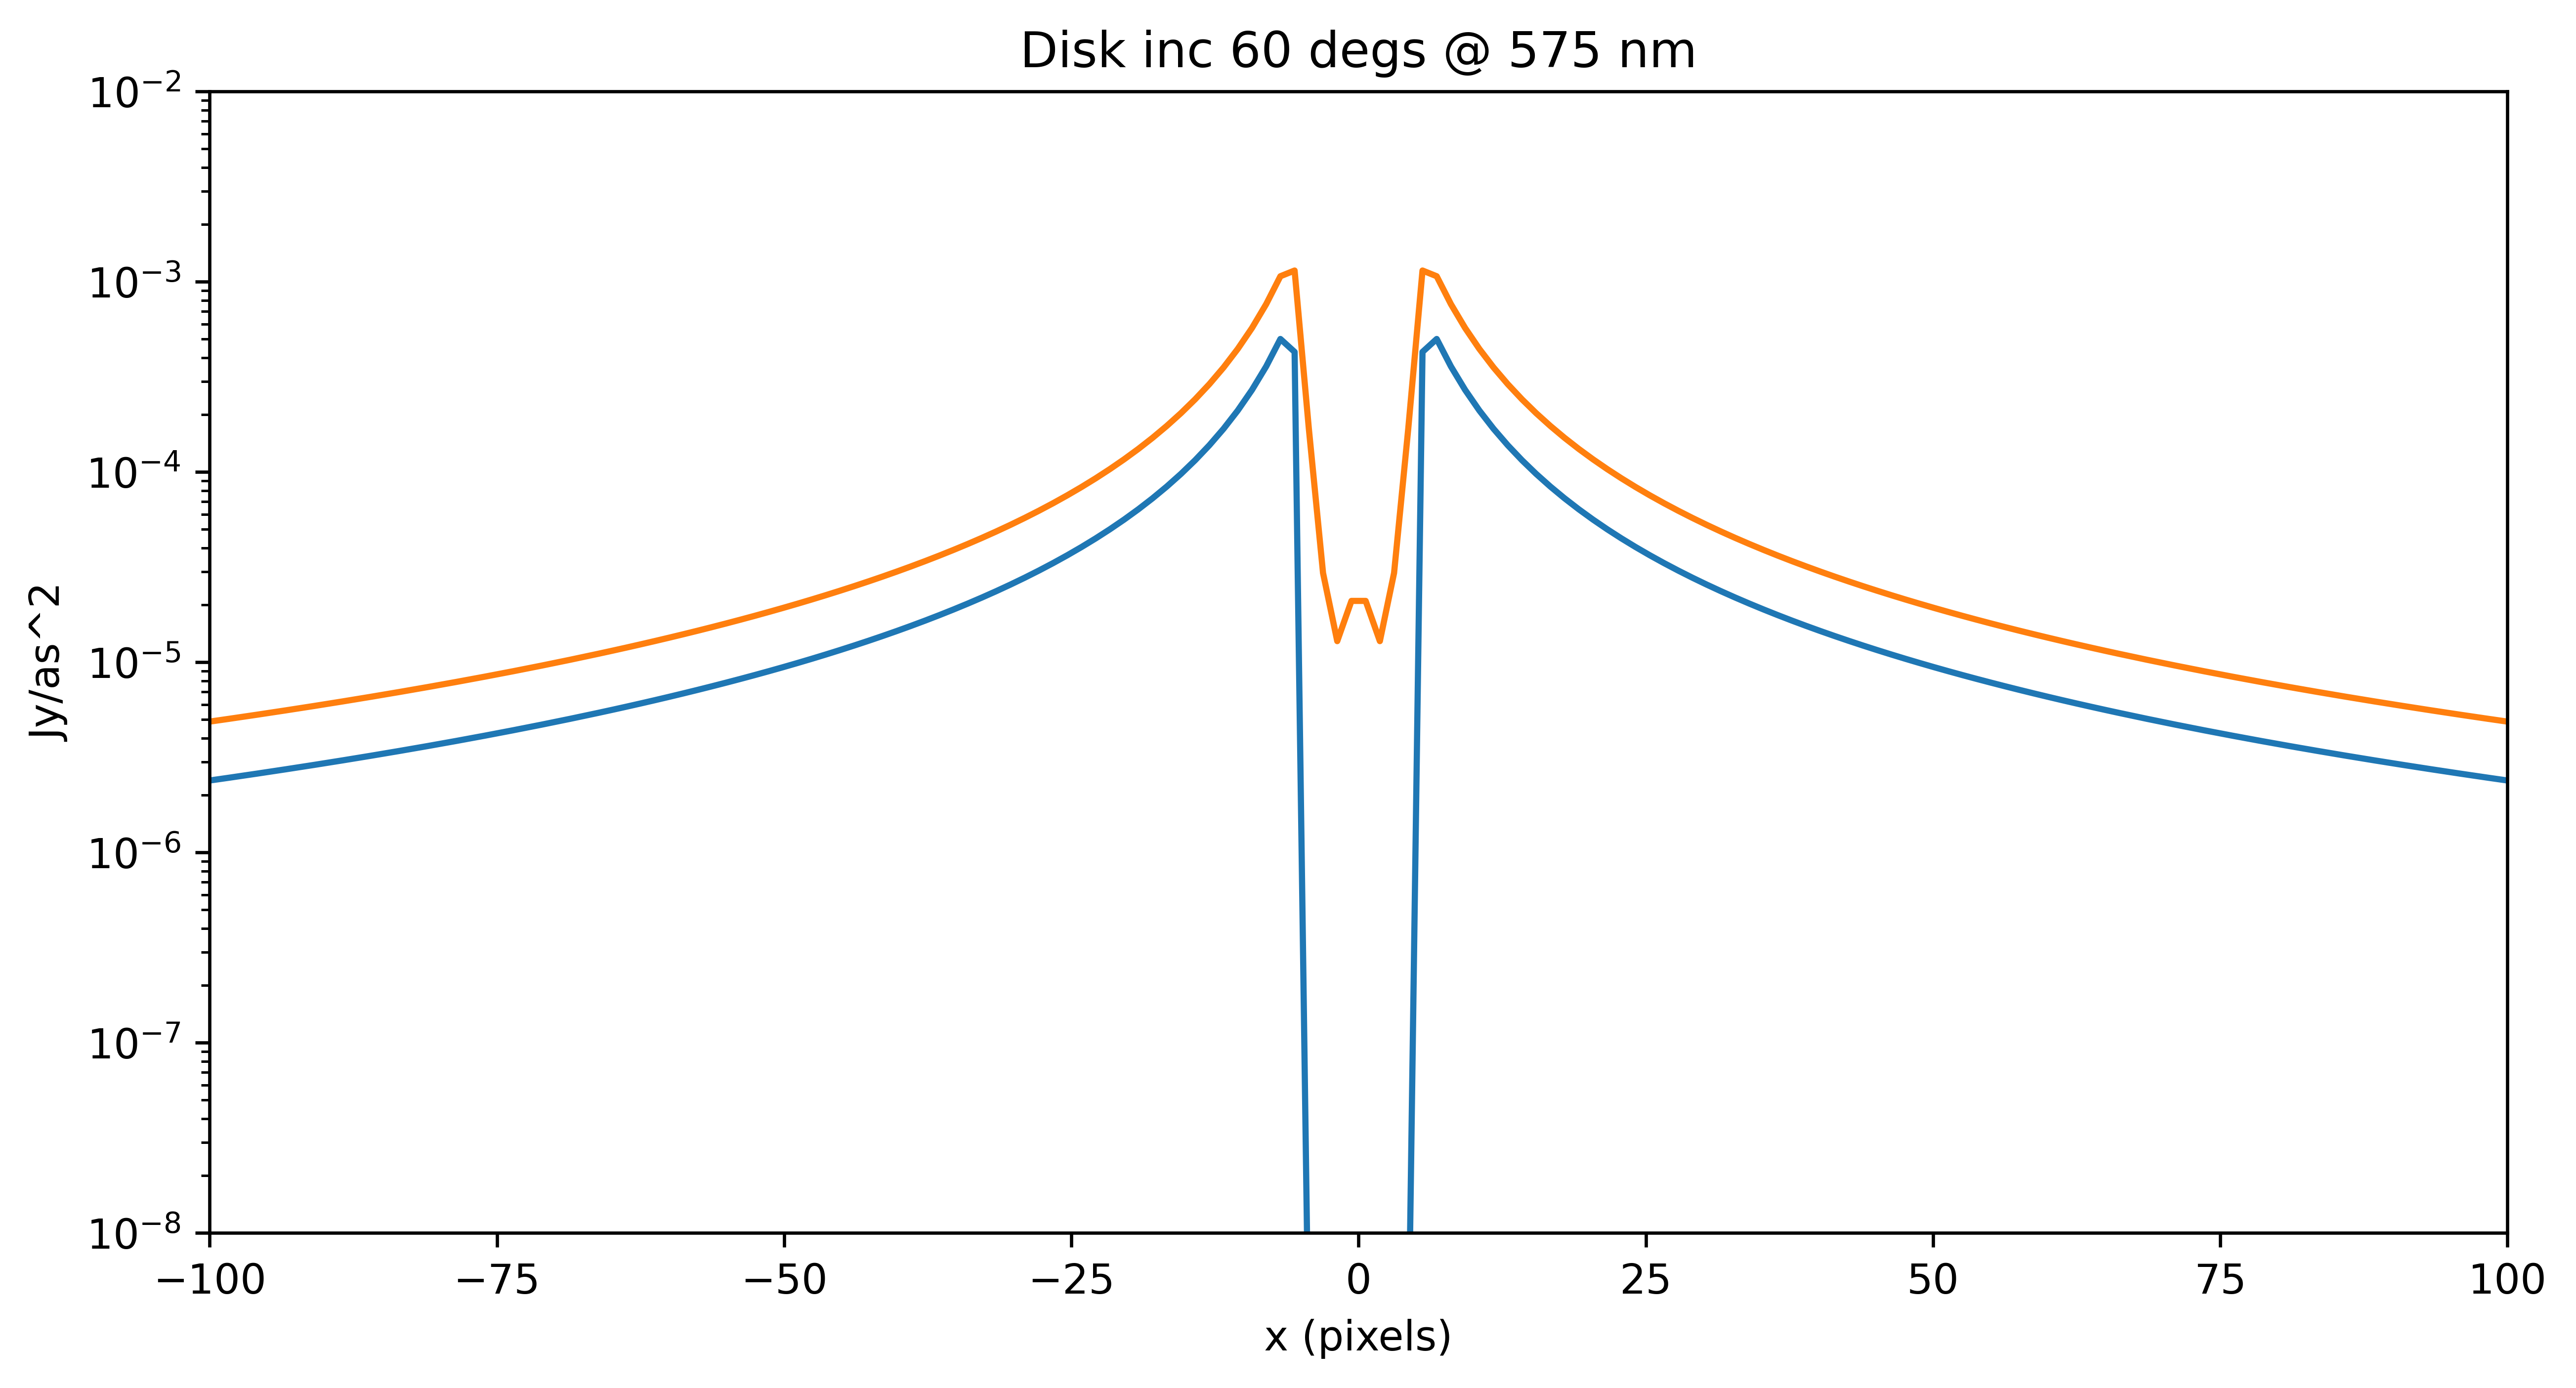

In [ ]:
import astropy.io.fits as fits
import os
import glob
from libmambapy import sign
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the output folder containing the FITS files
output_folder = 'output'

# Get a list of all FITS files in the output folder
fits_files = glob.glob(os.path.join(output_folder, '*.fits'))
# sort the files by the number in the filename
fits_files.sort(key=lambda x: int(x.split('/')[-1].split('-')[0]))

# Choose the desired wavelength (in microns)
desired_wavelength = 0.575  # Example: 1 micron

fig = plt.figure(figsize=(10, 5), dpi=600)
# Loop through each FITS file
for fits_file_number in [0,4]:
    if fits_file_number in [0,4]:
        pixel_scale = 2.470880491500521/2
    else:
        pixel_scale = 2

    # Open the FITS file
    with fits.open(fits_files[fits_file_number]) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        '''
        NAXIS1: length of wavelength vector (# of wavelengths)
        SPECRES: spectral resolution of wavelength vector
        LAMMIN: minimum wavelength
        LAMMAX: maximum wavelength
        '''
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break

        # Get the disk contrast cube
        disk_cube = hdul[2].data

        # Get header information from Extension 2
        diskheader = hdul[2].header
        '''
        NAXIS1: # of pixels in x dimension
        NAXIS2: # of pixels in y dimension
        NAXIS3: # of wavelengths+1
        SPECRES: spectral resolution of wavelength vector
        PXSCLMAS: pixel scale in milli-arcseconds
        IWA: inner working angle of the coronagraph in arcseconds
        DUSTBLOW: the dust blowout particle size in microns
        TSUB: the dust sublimation temperature in kelvins
        LNGND-N: longitude of the ascending node of the Nth disk component (degrees)
        I-N: inclination of the Nth disk component relative to system midplane (degrees)
        NZODIS-N: density in zodis of the Nth disk component
        R-N: circumstellar distance of the peak density of the Nth disk component (AU)
        DROR-N: value of the normalized Gaussian peak width of the Nth disk component
        RINNER-N: value of the inner truncation radius of the Nth disk component (AU)
        ETA-N: ratio of PR drag time to collision time for the blowout size for the Nth disk component
        HOR-N: normalized scale height for the Nth disk component
        G0-N – G2-N: 3 values of scattering asymmetry parameters for the Nth disk component
        W0-N – W2-N: 3 weights for each HG scattering phase function for the Nth disk component
        MINSIZE: minimum grain size considered
        MAXSIZE: maximum grain size considered
        '''

        # Extract relevant parameters from the header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        iwa = diskheader['IWA']           # Inner working angle in arcseconds
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        #print(f'Pixel scale: {pxsclmas} mas/pixel')
        #print(f'Inner working angle: {iwa*1000} mas')
        #print(f'Number of pixels in x dimension: {nxpix}')
        #print(f'Number of pixels in y dimension: {nypix}')

        # Get header information from Extension 4
        starheader = hdul[4].header
        '''
        Key header parameters:
        NAXIS1: # of time values
        NAXIS2: # of data values (wavelengths+15) for each time value
        PA: position angle of system midplane (degrees)
        I: inclination of system midplane (degrees)
        STARID: an internal catalog ID # for the star
        RA: right ascension of star (decimal degrees)
        DEC: declination of star (decimal degrees)
        *MAG: stellar empirical magnitude in the * filter band
        M_V: absolute V-band magnitude of star
        DIST: distance to star (pc)
        TYPE: spectral type of star
        LSTAR: bolometric stellar luminosity (solar luminosities)
        TEFF: stellar effective temperature (K)
        ANGDIAM: angular diameter of star (mas)
        MASS: stellar mass (solar masses)
        LOGG: log(stellar gravity) (cm/s2)
        RSTAR: stellar radius (solar radii)
        WDS_SEP: most recent separation of companion in WDS catalog, if it exists (arcsec)
        WDS_DMAG: delta mag of companion in WDS catalog, if it exists
        PMRA: proper motion in RA (mas/yr)
        PMDEC: proper motion in DEC (mas/yr)
        PXSCLMAS: pixel scale (mas)
        '''
        system_inc = int(starheader['I'])   

        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:] # Contrast map in contrast/pixel

        # Plot the disk from contrast map and the star flux
        disk_img = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e6/pixel_scale**2
        
        print(np.max(disk_img), pxsclmas, pixel_scale, nxpix)
        #plot along the x-axis
        print(fits_files[fits_file_number])
        plt.plot(np.linspace(-nxpix/2,nxpix/2,nxpix)*pixel_scale, disk_img[nypix//2])
        '''
        if fits_file_number == 0:
            np.save('../Toy_Coronagraph/tests/exovista'+str(0)+'.npy', np.array([np.linspace(-nxpix/2,nxpix/2,nxpix)*pixel_scale, disk_img[nypix//2]]))
        elif fits_file_number == 4:
            np.save('../Toy_Coronagraph/tests/exovista'+str(60)+'.npy', np.array([np.linspace(-nxpix/2,nxpix/2,nxpix)*pixel_scale, disk_img[nypix//2]]))
        '''
        plt.ylabel('Jy/as^2')
        plt.yscale('log')
        plt.ylim(1e-8,1e-2)
        plt.xlim(-100,100)
        plt.title(f'Disk inc {system_inc} degs @ {int(desired_wavelength*1000)} nm')
        plt.xlabel('x (pixels)')

plt.show()

In [ ]:
%%time
import itertools
import numpy as np
from astropy.io import fits
import tables
import os

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

wavelengths_nm = [575, 660, 730, 825] # meter
Ds = {"3m":3, "6m":6, "8m":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90] # system inclination in degrees

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)

for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    desired_wavelength = wavelength_nm/1000
    fits_file = f'output/{1000+i}-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits'
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break
        
        # Get the disk contrast cube
        disk_cube = hdul[2].data
        '''
        # Get header information from Extension 2
        diskheader = hdul[2].header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        print(pxsclmas == psf_scale*1000/2)
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        print(nypix == 2*target_pixel)
        # Get header information from Extension 4
        starheader = hdul[4].header
        system_inc = int(starheader['I'])
        print(system_inc == incs[i%8])
        '''
        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]

        super_disk = contrast_map*steflux(desired_wavelength*1000,lams,bnus)/psf_scale**2
        # Plot the disk from contrast map and the star flux
        pre_imgs[i] =  downsample_image(super_disk, 2, target_pixel)

# Save the pre-processed images
with tables.open_file('455_exovista.h5', 'a') as fitsh5:
    fitsh5.create_array('/', 'vortex', pre_imgs)


CPU times: user 993 ms, sys: 200 ms, total: 1.19 s
Wall time: 1.21 s


In [10]:
%%time
import itertools
import numpy as np
from astropy.io import fits
import tables
import os

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

wavelengths_nm = [575, 660, 730, 825] # meter
Ds = {"3m":3, "6m":6, "8m":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90] # system inclination in degrees

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)

for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    desired_wavelength = wavelength_nm/1000
    fits_file = f'output/{1100+i}-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits'
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break
        
        # Get the disk contrast cube
        disk_cube = hdul[2].data
        '''
        # Get header information from Extension 2
        diskheader = hdul[2].header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        print(pxsclmas == psf_scale*1000/2)
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        print(nypix == 2*target_pixel)
        # Get header information from Extension 4
        starheader = hdul[4].header
        system_inc = int(starheader['I'])
        print(system_inc == incs[i%8])
        '''
        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]

        super_disk = contrast_map*steflux(desired_wavelength*1000,lams,bnus)/psf_scale**2
        # Plot the disk from contrast map and the star flux
        pre_imgs[i] =  downsample_image(super_disk, 2, target_pixel)

# Save the pre-processed images
with tables.open_file('455_exovista.h5', 'a') as fitsh5:
    fitsh5.create_array('/', 'aplc', pre_imgs)


CPU times: user 970 ms, sys: 174 ms, total: 1.14 s
Wall time: 1.14 s


In [127]:
with tables.open_file('455_exovista_tmp.h5', 'r') as fitsh5:
    print(fitsh5)

455_exovista_tmp.h5 (File) ''
Last modif.: '2024-11-21T14:31:06+00:00'
Object Tree: 
/ (RootGroup) ''
/vortex (Array(96, 455, 455)) ''



In [14]:
np.max(pre_imgs[0])/4

0.0010896627583730936

3.1279717870424175


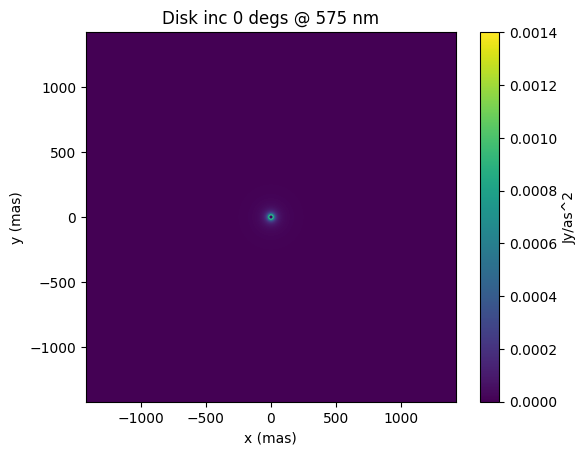

3.1279717870424175


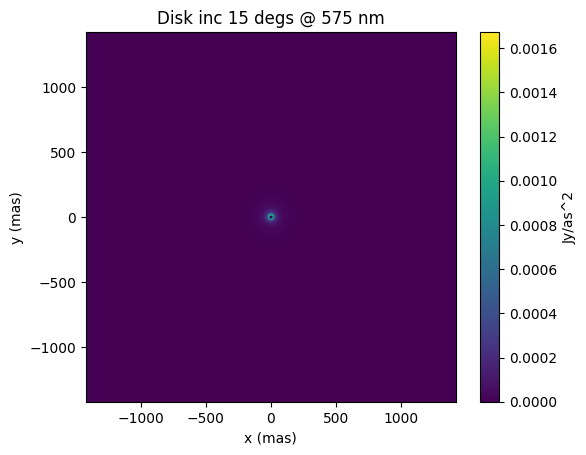

3.1279717870424175


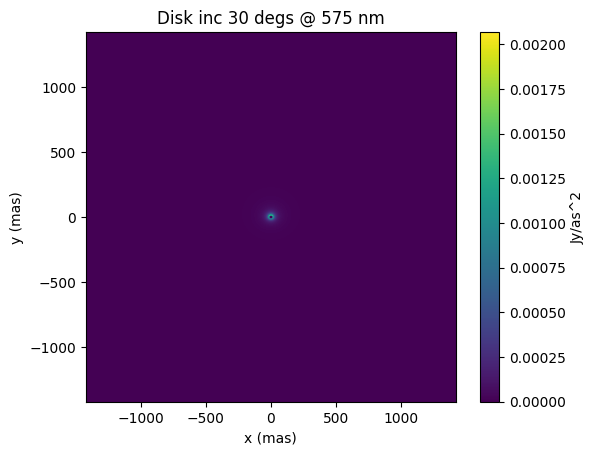

3.1279717870424175


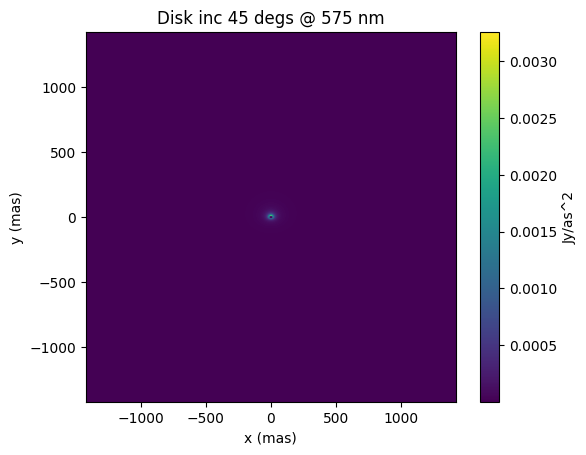

3.1279717870424175


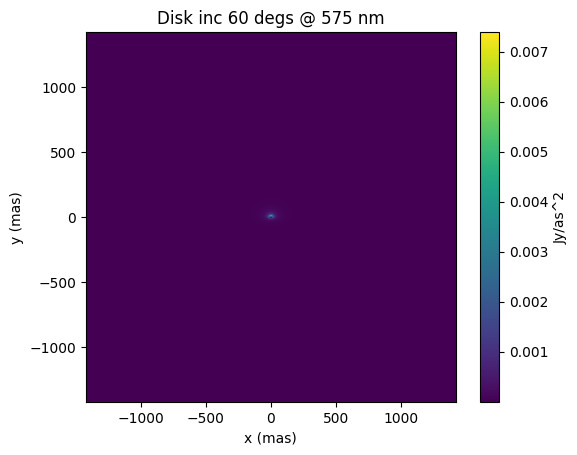

3.1279717870424175


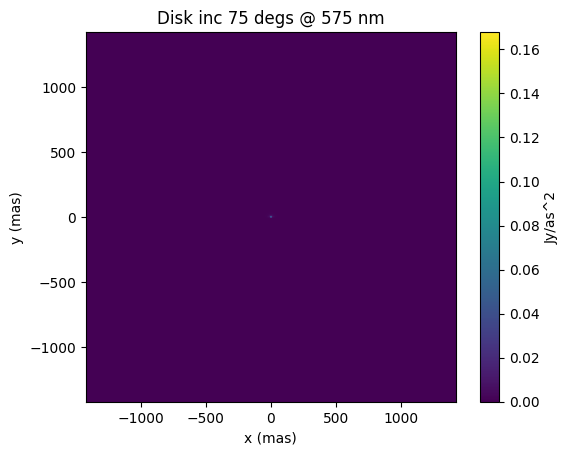

3.1279717870424175


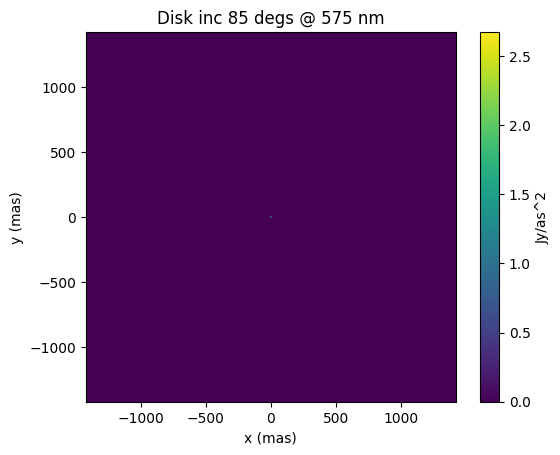

3.1279717870424175


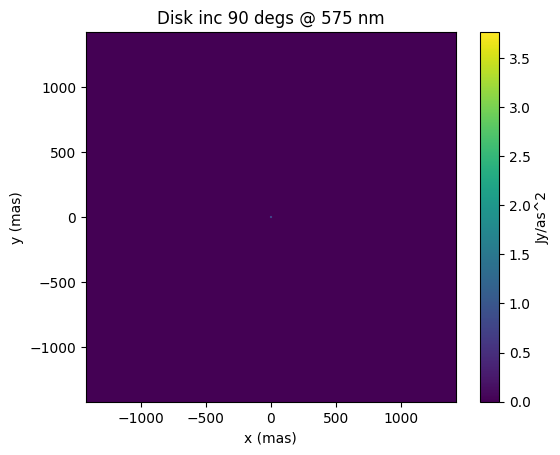

1.5639858935212088


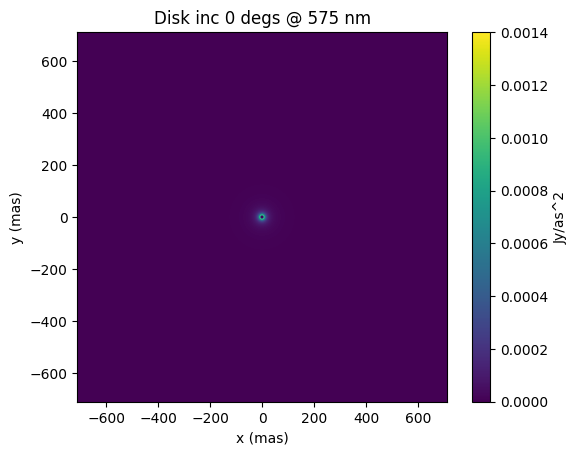

1.5639858935212088


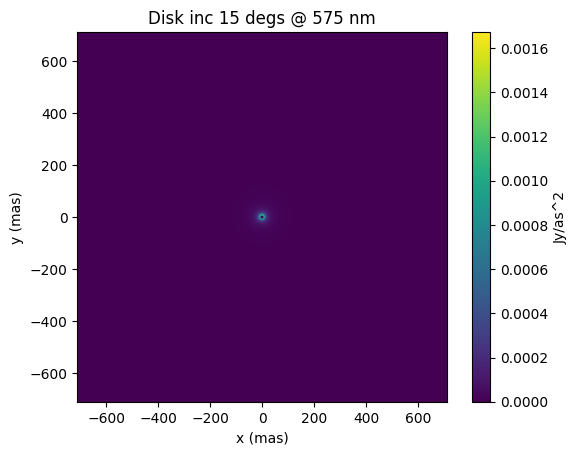

1.5639858935212088


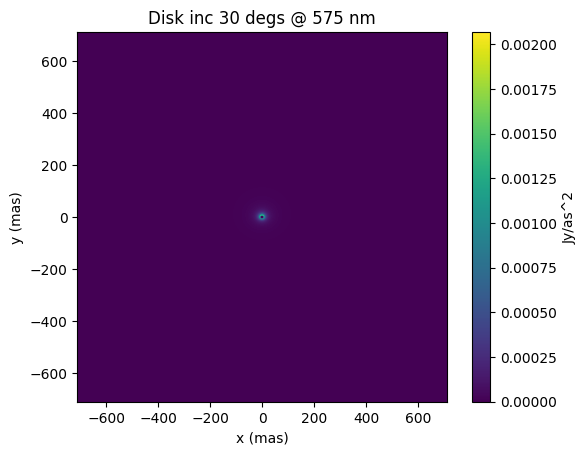

1.5639858935212088


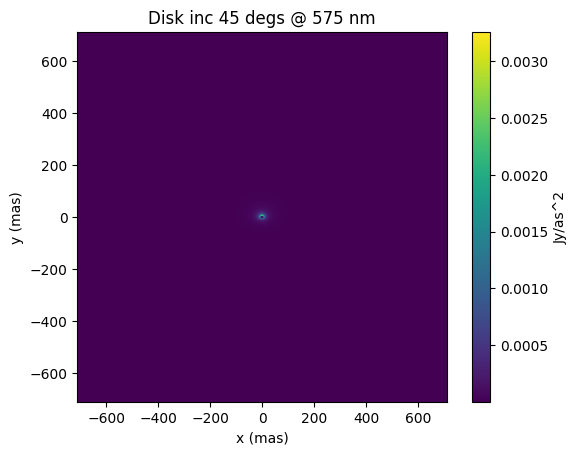

1.5639858935212088


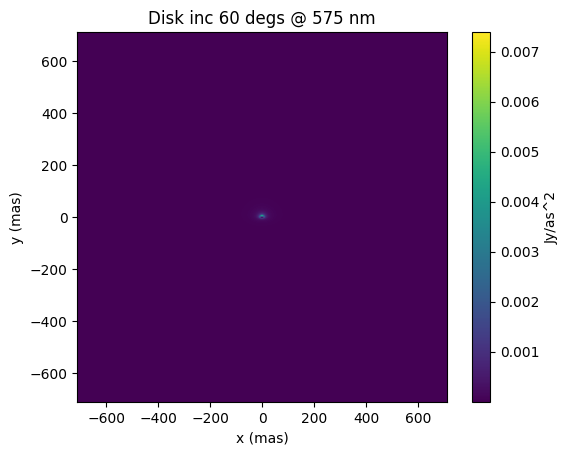

1.5639858935212088


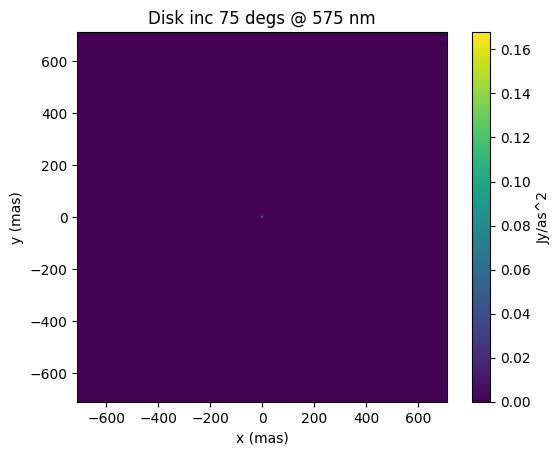

1.5639858935212088


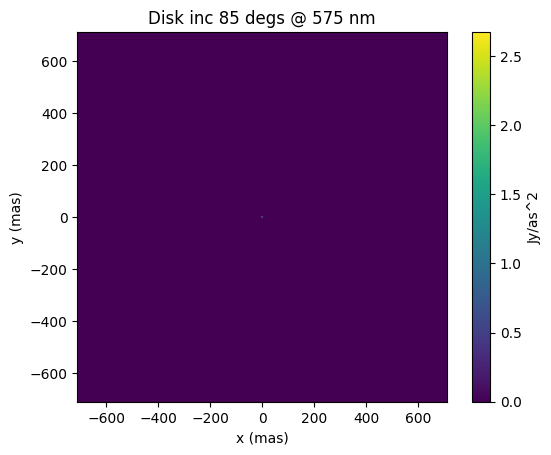

1.5639858935212088


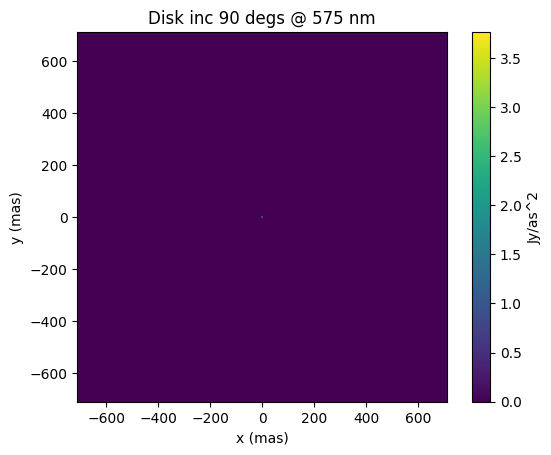

In [ ]:
import astropy.io.fits as fits
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the output folder containing the FITS files
output_folder = 'output'

# Get a list of all FITS files in the output folder
fits_files = glob.glob(os.path.join(output_folder, '*.fits'))
# sort the files by the number in the filename
fits_files.sort(key=lambda x: int(x.split('/')[-1].split('-')[0]))

# Choose the desired wavelength (in microns)
desired_wavelength = 0.575  # Example: 1 micron

# Loop through each FITS file
for fits_file in fits_files[::]:
    # Open the FITS file
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        '''
        NAXIS1: length of wavelength vector (# of wavelengths)
        SPECRES: spectral resolution of wavelength vector
        LAMMIN: minimum wavelength
        LAMMAX: maximum wavelength
        '''
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break

        # Get the disk contrast cube
        disk_cube = hdul[2].data

        # Get header information from Extension 2
        diskheader = hdul[2].header
        '''
        NAXIS1: # of pixels in x dimension
        NAXIS2: # of pixels in y dimension
        NAXIS3: # of wavelengths+1
        SPECRES: spectral resolution of wavelength vector
        PXSCLMAS: pixel scale in milli-arcseconds
        IWA: inner working angle of the coronagraph in arcseconds
        DUSTBLOW: the dust blowout particle size in microns
        TSUB: the dust sublimation temperature in kelvins
        LNGND-N: longitude of the ascending node of the Nth disk component (degrees)
        I-N: inclination of the Nth disk component relative to system midplane (degrees)
        NZODIS-N: density in zodis of the Nth disk component
        R-N: circumstellar distance of the peak density of the Nth disk component (AU)
        DROR-N: value of the normalized Gaussian peak width of the Nth disk component
        RINNER-N: value of the inner truncation radius of the Nth disk component (AU)
        ETA-N: ratio of PR drag time to collision time for the blowout size for the Nth disk component
        HOR-N: normalized scale height for the Nth disk component
        G0-N – G2-N: 3 values of scattering asymmetry parameters for the Nth disk component
        W0-N – W2-N: 3 weights for each HG scattering phase function for the Nth disk component
        MINSIZE: minimum grain size considered
        MAXSIZE: maximum grain size considered
        '''

        # Extract relevant parameters from the header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        print(pxsclmas)
        iwa = diskheader['IWA']           # Inner working angle in arcseconds
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        #print(f'Pixel scale: {pxsclmas} mas/pixel')
        #print(f'Inner working angle: {iwa*1000} mas')
        #print(f'Number of pixels in x dimension: {nxpix}')
        #print(f'Number of pixels in y dimension: {nypix}')

        # Get header information from Extension 4
        starheader = hdul[4].header
        '''
        Key header parameters:
        NAXIS1: # of time values
        NAXIS2: # of data values (wavelengths+15) for each time value
        PA: position angle of system midplane (degrees)
        I: inclination of system midplane (degrees)
        STARID: an internal catalog ID # for the star
        RA: right ascension of star (decimal degrees)
        DEC: declination of star (decimal degrees)
        *MAG: stellar empirical magnitude in the * filter band
        M_V: absolute V-band magnitude of star
        DIST: distance to star (pc)
        TYPE: spectral type of star
        LSTAR: bolometric stellar luminosity (solar luminosities)
        TEFF: stellar effective temperature (K)
        ANGDIAM: angular diameter of star (mas)
        MASS: stellar mass (solar masses)
        LOGG: log(stellar gravity) (cm/s2)
        RSTAR: stellar radius (solar radii)
        WDS_SEP: most recent separation of companion in WDS catalog, if it exists (arcsec)
        WDS_DMAG: delta mag of companion in WDS catalog, if it exists
        PMRA: proper motion in RA (mas/yr)
        PMDEC: proper motion in DEC (mas/yr)
        PXSCLMAS: pixel scale (mas)
        '''
        system_inc = int(starheader['I'])   

        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]
        # Calculate the extent for plotting based on pixel scale and IWA
        extent = pxsclmas*np.array([-nxpix/2+0.5, nxpix/2-0.5, -nypix/2+0.5, nypix/2-0.5]) # in milliarcseconds

        # Plot the disk from contrast map and the star flux
        disk_img = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e6/pixel_scale**2
        
        plt.imshow(disk_img, extent=extent, cmap='viridis', origin='lower')
        plt.colorbar(label='Jy/as^2')
        plt.ylabel('y (mas)')
        
        #np.save('../Toy_Coronagraph/tests/exovista'+str(system_inc)+'.npy', np.array([np.arange(extent[0], extent[1], pxsclmas), disk_img[nypix//2]]))
        #plt.plot(np.linspace(extent[0],extent[1],nxpix), disk_img[nxpix//2])
        #plt.ylabel('Jy/as^2')
        plt.title(f'Disk inc {system_inc} degs @ {int(desired_wavelength*1000)} nm')
        plt.xlabel('x (mas)')
        plt.show()
        plt.close()